In [7]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from qiskit.circuit.library.standard_gates import CHGate

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

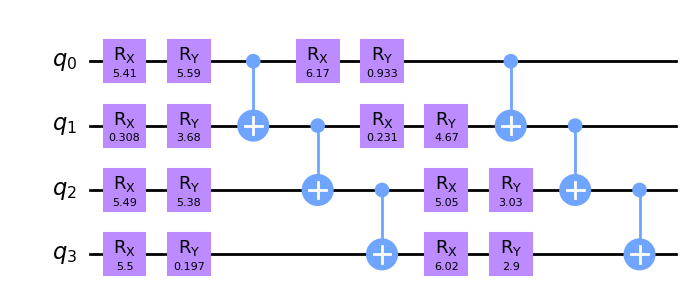

In [8]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([5.40530723, 0.30789834, 5.48565623, 5.49679285, 5.58904428, 3.67626375,
                            5.38444934, 0.19679063, 6.16917933, 0.2308673,  5.04796852, 6.02401649,
                            0.93282454, 4.6738944,  3.02576907, 2.90214658])

size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [9]:
def prune(oper):
    '''
    Takes in a matrix and removes the fractional part below 1e-6. Needed to pretty print output.
    '''
    for i in range(oper.shape[0]):
        for j in range(oper.shape[1]):
            x = np.real(oper[i, j])
            y = np.imag(oper[i, j] )
            tx = np.round_(x, 6)
            ty = np.round_(y, 6)
            oper[i, j] = tx + 1j*ty
    return oper

In [10]:
def Rx(theta):
    '''
    Define matrix representation of Rx gate
    '''
    return np.matrix([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]], dtype=complex)

In [11]:
def Ry(theta):
    '''
    Define matrix representation of Ry gate
    '''
    return np.matrix([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]], dtype=complex)

In [12]:
def Rz(theta):
    '''
    Define matrix representation of Rz gate
    '''
    return np.matrix([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]], dtype=complex)

In [13]:
def Bx():
    '''
    Define bilateral rotation Bx
    '''
    return prune(np.kron(Rx(-np.pi/2), Rx(-np.pi/2)))

In [14]:
def By():
    '''
    Define bilateral rotation By
    '''
    return prune(np.kron(Ry(-np.pi/2), Ry(-np.pi/2)))

In [15]:
def Bz():
    '''
    Define bilateral rotation Bz
    '''
    return prune(np.kron(Rz(-np.pi/2), Rz(-np.pi/2)))

In [16]:
def createOplist():
    '''
    Creates list of group element unitary representations
    '''
    opList = []
    opList.append(np.kron(np.eye(2), np.eye(2)))
    
    opList.append(prune(np.matmul(Bx(), Bx())))
    opList.append(prune(np.matmul(By(), By())))
    opList.append(prune(np.matmul(Bz(), Bz())))
    
    opList.append(prune(np.matmul(Bx(), By())))
    opList.append(prune(np.matmul(By(), Bz())))
    opList.append(prune(np.matmul(Bz(), Bx())))
    opList.append(prune(np.matmul(By(), Bx())))
    
    temp = prune(np.matmul(Bx(), By()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(By(), Bz()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(Bz(), Bx()))
    opList.append(prune(np.matmul(temp, temp)))
    
    temp = prune(np.matmul(By(), Bx()))
    opList.append(prune(np.matmul(temp, temp)))
    
    return opList

In [17]:
'''
Create list of unitaries.
'''
opList = createOplist()

In [18]:
'''
Define matrix representations of required gates.
'''
phiPlus = np.matrix([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]], dtype=complex)
phiMinus = np.matrix([[0.5, 0, 0, -0.5], [0, 0, 0, 0], [0, 0, 0, 0], [-0.5, 0, 0, 0.5]], dtype=complex)
psiPlus = np.matrix([[0, 0, 0, 0], [0, 0.5, 0.5, 0], [0, 0.5, 0.5, 0], [0, 0, 0, 0]], dtype=complex)
psiMinus = np.matrix([[0, 0, 0, 0], [0, 0.5, -0.5, 0], [0, -0.5, 0.5, 0], [0, 0, 0, 0]], dtype=complex)

In [19]:
def createWerner(F):
    '''
    Creates the matrix representation of the Werner state with parameter F.
    '''
    werner = np.zeros((4, 4), dtype=complex)
    werner += F*psiMinus
    werner += ((1-F)/3)*psiPlus
    werner += ((1-F)/3)*phiPlus
    werner += ((1-F)/3)*phiMinus

    return werner

In [20]:
'''
Extract the matrix representation of the state \rho_S
'''
psi = np.array(DensityMatrix.from_instruction(state.reverse_bits()))
rho = pt(psi, [3, 4], [2, 2, 2, 2])

In [21]:
'''
SDP to calculate the Fidelity. Refer to Section 5.
'''
shape = rho.shape

X = cp.Variable(shape, complex=True)
sig = cp.Variable(shape, complex=True)
G = cp.bmat([[rho, X.H],[X, sig]])

c = [sig>>0, G>>0, cp.real(cp.trace(sig))==1]

'''
Add the constraints to ensure that sig is G-symmetric
'''
for op in opList:
    c.append(op@sig == sig@op)

obj = cp.Maximize(0.5*(cp.real(cp.trace(X)) + cp.real(cp.trace(X.H))))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

Root Fidelity is : 0.9222341072756876


In [22]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.8505157486225844
